In [104]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import seaborn as sns
import numpy as np
from shapely.geometry import mapping, box
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

sns.set_style('white')
sns.set(font_scale=1.5)

os.chdir(os.path.join(et.io.HOME, 'earth-analytics')) #root directory

In [105]:
# Importing post fire Landsat data
all_landsat_bands_path = os.path.join("data", 
                                      "cold-springs-fire", 
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop", 
                                      "*band*.tif")

In [106]:
all_landsat_bands = glob(all_landsat_bands_path)
all_landsat_bands.sort()

In [107]:
landsat_post_fire_path = os.path.join("data", 
                                      "cold-springs-fire",
                                      "outputs", 
                                      "landsat_post_fire.tif") #output plot path

In [108]:
# Stacking post fire data
landsat_post_fire, landsat_post_fire_meta = es.stack(all_landsat_bands,
                                                     landsat_post_fire_path)


In [109]:
landsat_extent = plotting_extent(landsat_post_fire[0],
                                 landsat_post_fire_meta["transform"])

In [110]:
fire_boundary_path = os.path.join("data", 
                                  "cold-springs-fire",
                                  "vector_layers", 
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")



In [111]:
fire_boundary = gpd.read_file(fire_boundary_path)

# If the CRS are not the same, be sure to reproject
fire_bound_utmz13 = fire_boundary.to_crs(landsat_post_fire_meta['crs'])

In [112]:
#Post Fire NBR
landsat_postfire_nbr = (
    landsat_post_fire[4]-landsat_post_fire[6]) / (landsat_post_fire[4]+landsat_post_fire[6])

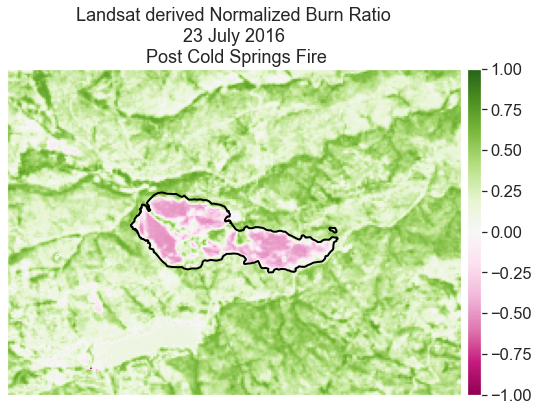

In [113]:
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(landsat_postfire_nbr,
              cmap='PiYG',
              vmin=-1, vmax=1,
              extent=landsat_extent,
              title="Landsat derived Normalized Burn Ratio\n 23 July 2016 \n Post Cold Springs Fire",
              ax=ax,
              scale=False)

fire_bound_utmz13.plot(ax=ax, color='None',
                       edgecolor='black', linewidth=2)
plt.show()

In [114]:
#Importing Pre-Fire landsat Data
all_landsat_bands_path2 = os.path.join("data", 
                                      "cold-springs-fire", 
                                      "landsat_collect",
                                      "LC080340322016070701T1-SC20180214145604",
                                      "crop", 
                                      "*band*.tif")

In [115]:
all_landsat_bands2 = glob(all_landsat_bands_path2)
all_landsat_bands2.sort()
landsat_pre_fire, landsat_pre_fire_meta = es.stack(all_landsat_bands2,
                                                     landsat_pre_fire_path) #Stacking Pre-fire data


In [116]:
landsat_pre_fire_path = os.path.join("data", 
                                      "cold-springs-fire",
                                      "outputs", 
                                      "landsat_pre_fire.tif") #output plot path

In [117]:
# Pre-Fire NBR
landsat_prefire_nbr = (
    landsat_pre_fire[4]-landsat_pre_fire[6]) / (landsat_pre_fire[4]+landsat_pre_fire[6])

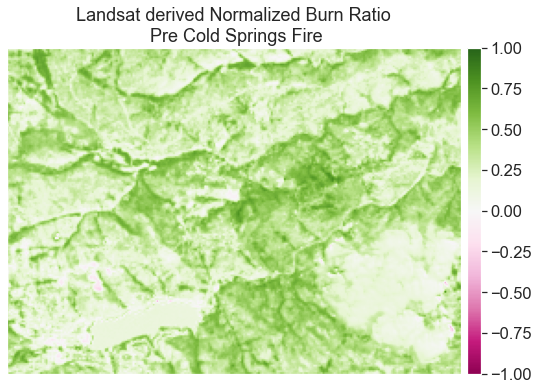

In [118]:
fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(landsat_prefire_nbr,
              cmap='PiYG',
              vmin=-1, vmax=1,
              title="Landsat derived Normalized Burn Ratio\n Pre Cold Springs Fire",
              ax=ax,
              scale=False)

plt.show()

In [119]:
#Calculate dNBR:
dnbr_landsat = landsat_prefire_nbr - landsat_postfire_nbr

In [120]:
dnbr_landsat

array([[ 0.06053689,  0.09801085,  0.13565655, ..., -0.02277766,
        -0.03019354,  0.00112735],
       [ 0.03737938,  0.09320462,  0.11856693, ..., -0.00827491,
        -0.0043851 ,  0.0011485 ],
       [ 0.00139974,  0.06205685,  0.08142801, ..., -0.00807687,
         0.0064772 ,  0.00447502],
       ...,
       [-0.07159956, -0.00260068,  0.02915099, ..., -0.01685437,
         0.02431214,  0.03168177],
       [ 0.0833712 , -0.14558633, -0.07208158, ..., -0.03929183,
        -0.02250457, -0.01183646],
       [-0.111083  ,  0.02821737, -0.00633484, ...,  0.00962946,
        -0.02222265, -0.03099946]])

In [121]:
class_bins = [dnbr_landsat.min(), -0.1, 0.1, 0.27, 0.66, np.inf] # categorizing dNBR values
class_bins

[-0.744511211541461, -0.1, 0.1, 0.27, 0.66, inf]

In [122]:
dnbr_class = np.digitize(dnbr_landsat, class_bins)

In [123]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"] 

nbr_colors = ["g", "yellowgreen",
              "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

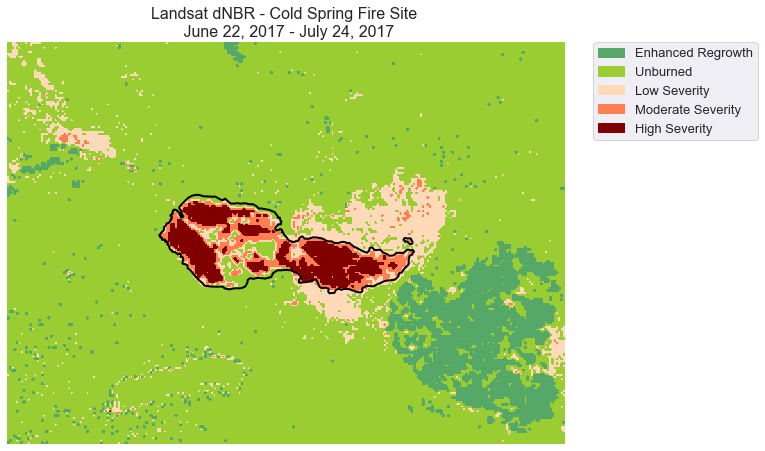

In [124]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(dnbr_class,
               cmap=nbr_cmap,
               extent=landsat_extent)

fire_bound_utmz13.plot(ax=ax, color='None',
                       edgecolor='black',
                       linewidth=2)

values = np.unique(dnbr_class.ravel())

ep.draw_legend(im,
               classes=values,
               titles=dnbr_cat_names) #CUSTOM LEGEND FOR PLOTTING

ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

ax.set_axis_off()
plt.show()


In [125]:
# Calculating area of severe burn:
landsat_pixel = 30 * 30 # spatial resolution of Landsat8 image; one pixel = 30m X 30m
burned_landsat = (dnbr_class[dnbr_class == 5]).size
burned_landsat
burned_landsat = np.multiply(burned_landsat, landsat_pixel)

print("Landsat Severe Burn Area:", burned_landsat)

Landsat Severe Burn Area: 950400
